In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
%matplotlib inline

#----------for loading MagIC things---------
if '/home/ryadav/GIT/magic/bin' not in sys.path:
    sys.path.append('/home/ryadav/GIT/magic/bin')

if '/home/ryadav/GIT/magic/python' not in sys.path:
    sys.path.append('/home/ryadav/GIT/magic/python')
    
from magic import *
#-------------------------------------------


path = '/media/ryadav/Seagate Expansion Drive/Data/'\
       'GWDG/finished/zonal_runs/1e-4/NSD/Pm1_Pr1_eta0.35_Ek1E-4_Ra3E7_no-slip_dyn'
os.chdir(path)
#os.getcwd()

def get_rand_mov_frame(path,stan=True,shuf=True):
    
    os.chdir(path)
    
    movies = {'Br_surf':'Br_R=C1_mov.tag_r', 'Vr':'Vr_R=C2_mov.tag_r',
              'Vp':'Vp_R=C3_mov.tag_r', 'Vt':'Vt_R=C4_mov.tag_r'}
    cols = 'lats lons Br_surf dBr_dt_surf Vr Vt Vp'.split()
    
    for key, value in movies.items():
        if key == 'Br_surf':
            mov_frames =  movie.Movie(file=value, iplot=False)
            nframes = mov_frames.data.shape[1] # frame shape: [useless,frame_ind,phi,theta]
            nphi = mov_frames.n_phi_tot
            ntheta = mov_frames.n_theta_max
            # random int between 0 and nframes-1 
            # (-1 is to avoid error at last frame for dBr/dt)
            rand_int = np.random.randint(0,nframes-1) #random int between 0 and nframes
            
            #declare main dataframe
            df_out = pd.DataFrame(np.zeros((ntheta*nphi, len(cols))), columns=cols)
            #assign Br_surf column
            df_out[key] = mov_frames.data[0,rand_int,:,:].astype('float32').ravel()
            # calculate simple dBr/dt as br[i+1]-br[i] and assign
            df_out['dBr_dt_surf'] =  (mov_frames.data[0,rand_int+1,:,:]
                                    -mov_frames.data[0,rand_int,:,:]).astype('float32').ravel()
        else:
            mov_frames =  movie.Movie(file=value, iplot=False)
            #assign other columns
            df_out[key] = mov_frames.data[0,rand_int,:,:].astype('float32').ravel()

    #define 2D lons and lats
    pphi, ttheta = np.mgrid[-np.pi:np.pi:nphi*1j, np.pi/2.:-np.pi/2.:ntheta*1j]
    df_out['lons'] = pphi.ravel().astype('float32')
    df_out['lats'] = ttheta.ravel().astype('float32')
    
    # standardise data (including output data) for ML 
    if stan==True:
        scaled_features = StandardScaler().fit_transform(df_out.values)
        df_out = pd.DataFrame(scaled_features, index=df_out.index, columns=df_out.columns)
    
    # Shuffle data for ML
    if shuf==True: df_out = shuffle(df_out).reset_index(drop=True)
    
    return df_out


In [2]:
if False:

    from sklearn.tree import DecisionTreeRegressor
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict

    df = get_rand_mov_frame(path)#.sample(100000)

    X = df.drop(['Vr','Vt','Vp'],axis=1)
    y = df[['Vt','Vp']]


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

    train_rmse_scores_means = []
    train_rmse_scores_std = []

    tree_depths = np.linspace(2,30,15)[::2]
    print('Provided tree depths', tree_depths)

    for depth in tree_depths:
        # define and fit a model
        #regr = DecisionTreeRegressor(max_depth=depth)
        regr = RandomForestRegressor(n_estimators=10, max_depth=depth)
        regr.fit(X_train, y_train)

        scores = cross_val_score(regr, X_train, y_train, cv=5, scoring="neg_mean_squared_error")
        # RMSE score 0 is ideal
        # train_rmse_scores = np.sqrt(-scores)
        train_rmse_scores_means.append(np.sqrt(-scores).mean())
        train_rmse_scores_std.append(np.sqrt(-scores).std())
        print('Tree with depth', int(depth), 'done.')
    train_rmse_scores_means = np.asarray(train_rmse_scores_means)
    train_rmse_scores_std = np.asarray(train_rmse_scores_std) 

    #predicted = cross_val_predict(regr, X_train, y_train, cv=3)


    plt.plot(tree_depths, train_rmse_scores_means)
    #plt.plot(tree_depths, train_rmse_scores_means+train_rmse_scores_std, '.r')
    #plt.plot(tree_depths, train_rmse_scores_means-train_rmse_scores_std, '.r')
    plt.xlabel('Tree Depth')
    plt.ylabel('RMSE')

    #y_test_predict = regr.predict(X_test)
    #fig, ax = plt.subplots()
    #ax.scatter(y_test.values[:,1], y_test_predict[:,1], edgecolors=(0, 0, 0))
    #ax.set_xlabel('Measured')
    #ax.set_ylabel('Predicted')
    #plt.show()

Provided tree depths [ 2.  6. 10. 14. 18. 22. 26. 30.]
Tree with depth 2 done.
Tree with depth 6 done.
Tree with depth 10 done.


KeyboardInterrupt: 

In [4]:
if False:
    # Experimenting with multi output method with Adaboost regressor
    from sklearn.multioutput import MultiOutputRegressor
    from sklearn.ensemble import AdaBoostRegressor

    #max_depth = 30
    #regr_multi_ada = MultiOutputRegressor(
    #                    AdaBoostRegressor(
    #                            DecisionTreeRegressor(max_depth=4),
    #                            n_estimators=300)
    #                                   )
    #regr_multi_ada.fit(X_train, y_train)


    train_rmse_scores_means = []
    train_rmse_scores_std = []

    tree_depths = np.linspace(10,22,5)
    print('Provided tree depths', tree_depths)

    for depth in tree_depths:
        # define and fit a model
        #regr = DecisionTreeRegressor(max_depth=depth)
        regr_multi_ada = MultiOutputRegressor(
                             AdaBoostRegressor(
                                DecisionTreeRegressor(max_depth=depth),
                                n_estimators=30) )
        regr_multi_ada.fit(X_train, y_train)

        scores = cross_val_score(regr_multi_ada, X_train, y_train, cv=3, 
                                 scoring="neg_mean_squared_error")

        train_rmse_scores_means.append(np.sqrt(-scores).mean())
        train_rmse_scores_std.append(np.sqrt(-scores).std())
        print('Tree with depth', int(depth), 'done.')
    train_rmse_scores_means = np.asarray(train_rmse_scores_means)
    train_rmse_scores_std = np.asarray(train_rmse_scores_std) 

    plt.plot(tree_depths, train_rmse_scores_means)

    plt.xlabel('Tree Depth')
    plt.ylabel('RMSE')


Frame 0 done.
Frame 1 done.
Frame 2 done.
Frame 3 done.
Frame 4 done.
Frame 5 done.
Frame 6 done.
Frame 7 done.
Frame 8 done.
Frame 9 done.
Frame 10 done.
Frame 11 done.
Frame 12 done.
Frame 13 done.
Frame 14 done.
Frame 15 done.
Frame 16 done.
Frame 17 done.
Frame 18 done.
Frame 19 done.
Frame 20 done.
Frame 21 done.
Frame 22 done.
Frame 23 done.
Frame 24 done.
Frame 25 done.
Frame 26 done.
Frame 27 done.
Frame 28 done.
Frame 29 done.
[0.88715694 0.69057498 0.6849429  0.62464335 0.61440525 0.59872056
 0.5913253  0.57115043 0.57685899 0.54055928 0.60289557 0.56550571
 0.51384412 0.58657286 0.57307032 0.54388415 0.56417442 0.57557993
 0.52676834 0.5573407  0.54791286 0.54706826 0.51699621 0.53132686
 0.57124638 0.56793163 0.51137942 0.51318662 0.54977589 0.50450625]


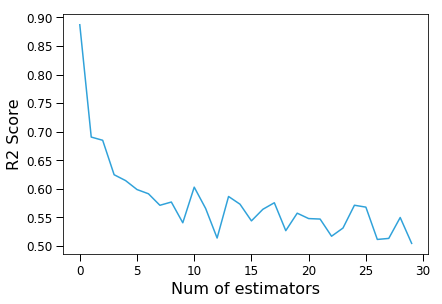

In [7]:

if False:
    # test with batch learning, i.e. using different movie frames to train a single method

    from sklearn.ensemble import RandomForestRegressor
    from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
    from sklearn.metrics import r2_score

    regr = RandomForestRegressor(warm_start = True, n_estimators = 1, max_depth=20)
    train_rmse_scores_means = []
    train_rmse_scores_std = []
    r2_scores = []

    for i in range(30):
        df = get_rand_mov_frame(path).sample(10000)
        X = df.drop(['Vr','Vt','Vp'],axis=1)
        y = df[['Vt','Vp']]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
        regr.fit(X_train, y_train)
        
        scores = cross_val_score(regr, X_train, y_train, cv=5, scoring="neg_mean_squared_error")
        train_rmse_scores_means.append(np.sqrt(-scores).mean())
        train_rmse_scores_std.append(np.sqrt(-scores).std())
        
        y_test_predict = regr.predict(X_test)
        r2_scores.append(r2_score(y_test.values[:,0], y_test_predict[:,0]))
        
        print('Frame', i, 'done.')
        
        # Add a new tree for training using new frame 
        # accompanies the warm_start option
        regr.n_estimators += 1
        
    train_rmse_scores_means = np.asarray(train_rmse_scores_means)
    train_rmse_scores_std = np.asarray(train_rmse_scores_std)
    r2_scores = np.asarray(r2_scores)

    print(train_rmse_scores_means)
    #plt.plot(train_rmse_scores_means); plt.ylabel('RMSE')
    plt.plot(train_rmse_scores_means); plt.ylabel('R2 Score')
    plt.xlabel('Num of estimators')
    


RMSE on trainig frame 0.1722572706454283
RMSE std on trainig frame 0.0016743415493504223
R2 score: 0.9731260025891186




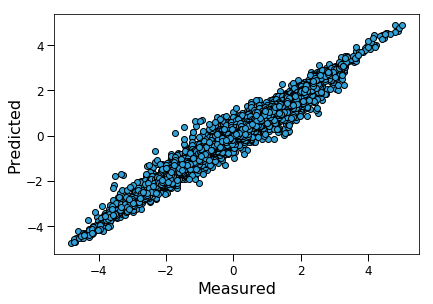

RMSE on another test frame 0.1836748453744361
RMSE std on another test frame 0.003030763959346099
R2 score: -0.33073667098508874


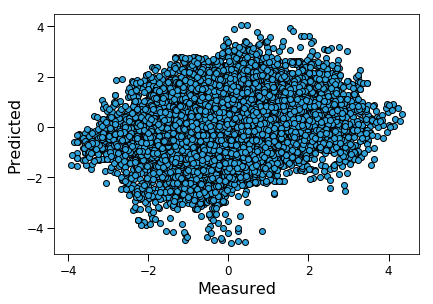

In [165]:
# Training forest on one frame and applyin it to some other frame
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score

# train the forest on one frame
df = get_rand_mov_frame(path)
X = df.drop(['Vr','Vt','Vp'],axis=1)
y = df[['Vt','Vp']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
regr = RandomForestRegressor(n_estimators=10, max_depth=22, random_state=42)
regr.fit(X_train, y_train)
scores = cross_val_score(regr, X_train, y_train, cv=5, scoring="neg_mean_squared_error")
print('RMSE on trainig frame', np.sqrt(-scores).mean())
print('RMSE std on trainig frame', np.sqrt(-scores).std())



y_test_predict = regr.predict(X_test)
print('R2 score:', r2_score(y_test.values[:,0], y_test_predict[:,0]))
print('\n')
fig, ax = plt.subplots()
ax.scatter(y_test.values[:,0], y_test_predict[:,0], edgecolors=(0, 0, 0))
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

# Get performance on a new frame 
df = get_rand_mov_frame(path)
X = df.drop(['Vr','Vt','Vp'],axis=1)
y = df[['Vt','Vp']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
scores = cross_val_score(regr, X_train, y_train, cv=5, scoring="neg_mean_squared_error")
print('RMSE on another test frame', np.sqrt(-scores).mean())
print('RMSE std on another test frame', np.sqrt(-scores).std())

y_test_predict = regr.predict(X_test)
print('R2 score:', r2_score(y_test.values[:,0], y_test_predict[:,0]))
fig, ax = plt.subplots()
ax.scatter(y_test.values[:,0], y_test_predict[:,0], edgecolors=(0, 0, 0))
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()


